# Customer & Marketing Analytics Module
## This module has 2 major components:
### Customer Segmentation (K-Means clustering)
### Customer Churn Prediction
### Customer Lifetime Value (CLV) estimation
### Segment-level insights & marketing actions

## Load Processed Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT = Path("../")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

rfm = pd.read_csv(DATA_PROCESSED / "customer_rfm_summary.csv")
behavior = pd.read_csv(DATA_PROCESSED / "customer_features_for_model.csv")

df = rfm.merge(behavior, on="Account_Number", how="left")
df.head()

,Account_Number,last_txn_date,frequency,monetary,avg_monetary,customer_age,customer_income,account_balance,recency_days,txn_count,total_spend,avg_spend,std_spend,failed_txn_count,online_txn_count,Discount_Applied_mean,Loyalty_Points_Earned_sum,online_txn_ratio,failed_txn_ratio
0,AAGF56964741331151,2023-12-15 09:18:14,1,4132.80,4132.80,32,117819.25,15563.02,402,1,4132.80,4132.80,NaN,1,0,0.0,484,0.0,1.0
1,AAHF65030524114207,2023-03-03 22:30:11,1,2836.60,2836.60,58,109834.12,6317.92,688,1,2836.60,2836.60,NaN,0,0,1.0,486,0.0,0.0
2,AAJK21289915114551,2023-03-27 21:16:09,1,1503.49,1503.49,49,87552.61,1876.15,664,1,1503.49,1503.49,NaN,0,0,0.0,260,0.0,0.0
3,AANF38183924516791,2024-03-22 13:40:48,1,875.14,875.14,34,131361.80,13445.36,303,1,875.14,875.14,NaN,1,0,0.0,79,0.0,1.0
4,AASV46584639248878,2025-01-12 13:12:40,1,3773.31,3773.31,21,52507.80,1899.08,7,1,3773.31,3773.31,NaN,0,0,1.0,231,0.0,0.0


## Customer Segmentation (K-Means)
### Goal: Build segments that marketing teams can act on.
#### We will create a segmentation dataset using:
#### RFM metrics
#### Behavioral features
#### Category-spend ratios (if available)

In [24]:
segment_features = [
    "recency_days",
    "frequency",
    "monetary",
    "avg_monetary",
    "customer_age",
    "customer_income",
    "account_balance",
    "avg_spend",
    "std_spend",
    "txn_count",
    "online_txn_ratio",
    "failed_txn_ratio"
]

# Remove missing columns (if any)
segment_features = [col for col in segment_features if col in df.columns]

seg_df = df[segment_features].fillna(0)


### Standardize

In [25]:
scaler = StandardScaler()
seg_scaled = scaler.fit_transform(seg_df)

### Elbow Method to find best K

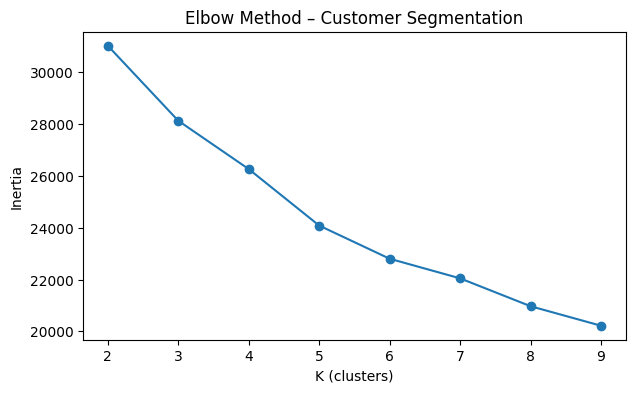

In [26]:
inertias = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(seg_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method – Customer Segmentation")
plt.xlabel("K (clusters)")
plt.ylabel("Inertia")
plt.show()


### Silhouette Scores

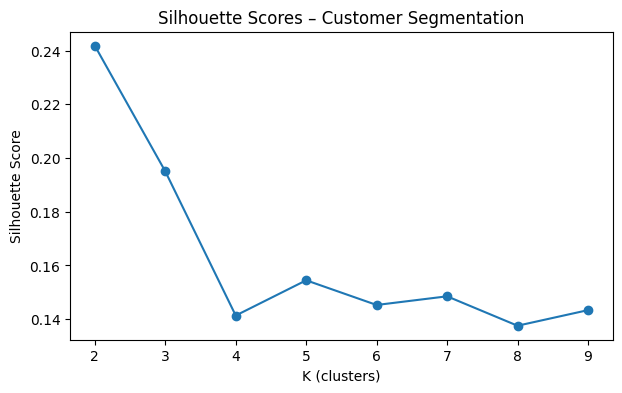

[0.24180373677835074,
 0.1950361087538615,
 0.14133189973037985,
 0.1544539865527313,
 0.14526469194806796,
 0.148489770881111,
 0.1375407426508566,
 0.14334482813984142]

In [27]:
sil_scores = []
for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(seg_scaled)
    sil = silhouette_score(seg_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(7, 4))
plt.plot(K_range, sil_scores, marker="o")
plt.title("Silhouette Scores – Customer Segmentation")
plt.xlabel("K (clusters)")
plt.ylabel("Silhouette Score")
plt.show()

sil_scores

### Fit Final K-Means Model

In [28]:
best_k = sil_scores.index(max(sil_scores)) + 2  
best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
df["segment"] = kmeans.fit_predict(seg_scaled)
df["segment"].value_counts()

segment
1    2743
0    2646
Name: count, dtype: int64

### Analyze Segments

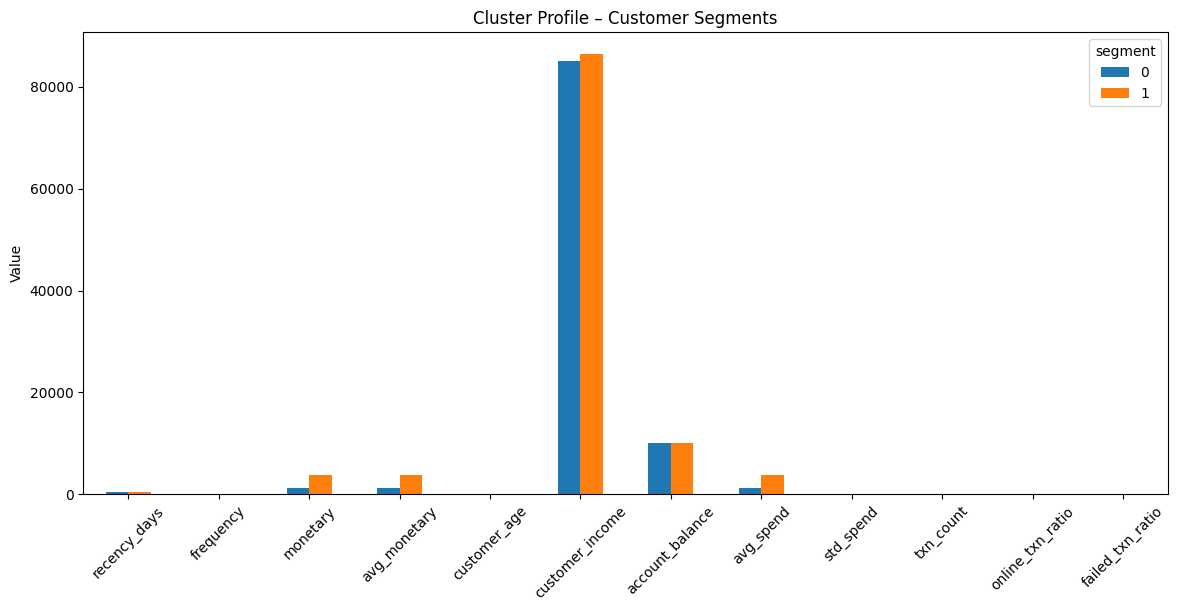

In [29]:
segment_profile = df.groupby("segment")[segment_features].mean()
segment_profile.round(2)
segment_profile.T.plot(kind="bar", figsize=(14, 6))
plt.title("Cluster Profile – Customer Segments")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

### Segment Naming (Marketing-friendly)
#### Use logic like:
##### High spend + high income + low recency → “Premium Loyalists”
##### Low spend + low income → “Price Sensitive”
##### High volatility + many failed transactions → “Unstable Risky Users”
##### Young + high online ratio → “Digital Millennials”

In [30]:
def name_segment(row):
    if row["monetary"] > df["monetary"].median() and row["online_txn_ratio"] > 0.5:
        return "Digital High-Spenders"
    elif row["customer_income"] < df["customer_income"].median():
        return "Value Seekers"
    else:
        return "Mass Affluent"

df["segment_name"] = df.apply(name_segment, axis=1)
df["segment_name"].value_counts()

segment_name
Mass Affluent    2695
Value Seekers    2694
Name: count, dtype: int64

## Customer Churn Prediction

In [31]:
transactions = pd.read_csv(DATA_PROCESSED / "transactions_feature_engineered.csv")

last_txn = transactions.groupby("Account_Number")["Transaction_Date"].max().reset_index()
last_txn["Transaction_Date"] = pd.to_datetime(last_txn["Transaction_Date"])

reference_date = last_txn["Transaction_Date"].max()
last_txn["days_since_last_txn"] = (reference_date - last_txn["Transaction_Date"]).dt.days

last_txn["churn_flag"] = (last_txn["days_since_last_txn"] > 90).astype(int)
df = df.merge(last_txn[["Account_Number", "days_since_last_txn", "churn_flag"]], 
              on="Account_Number", how="left")

### Prepare Churn Dataset

In [32]:
churn_features = segment_features + ["days_since_last_txn"]
X = df[churn_features].fillna(0)
y = df["churn_flag"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

### Build Churn Models
#### Baseline: Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

clf_lr = Pipeline([
    ("scale", StandardScaler()),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced"))
])

clf_lr.fit(X_train, y_train)
y_proba_lr = clf_lr.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_proba_lr)


0.9999697336561743

### Stronger Model: Random Forest

In [34]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_proba_rf)


1.0

### Churn Evaluation Plots
#### ROC curve

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_rf, tpr_rf, label="RandomForest")
plt.plot([0,1], [0,1], "--", color="gray")
plt.title("ROC Curve – Churn Prediction")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

#### Churn risk distribution

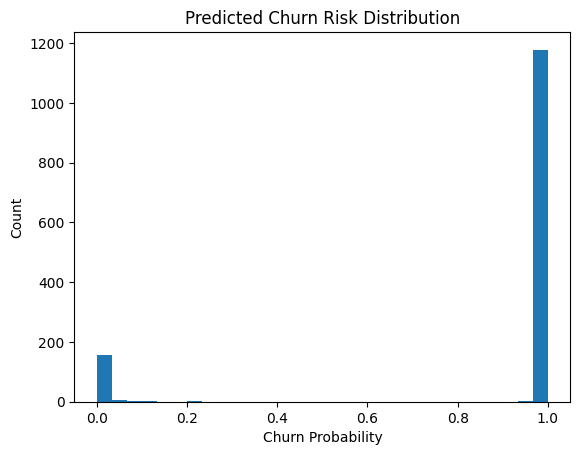

In [35]:
plt.hist(y_proba_rf, bins=30)
plt.title("Predicted Churn Risk Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Count")
plt.show()

## Marketing Recommendations Based on Segments + Churn

In [36]:
def marketing_action(row):
    if row["segment_name"] == "Digital High-Spenders" and row["churn_flag"] == 1:
        return "Offer cashback on online purchases"
    elif row["segment_name"] == "Value Seekers":
        return "Promote low-interest EMI offers"
    elif row["segment_name"] == "Mass Affluent":
        return "Cross-sell wealth management products"
    return "General engagement email"

df["recommended_action"] = df.apply(marketing_action, axis=1)
df[["Account_Number", "segment_name", "churn_flag", "recommended_action"]].head()


,Account_Number,segment_name,churn_flag,recommended_action
0,AAGF56964741331151,Mass Affluent,1,Cross-sell wealth management products
1,AAHF65030524114207,Mass Affluent,1,Cross-sell wealth management products
2,AAJK21289915114551,Mass Affluent,1,Cross-sell wealth management products
3,AANF38183924516791,Mass Affluent,1,Cross-sell wealth management products
4,AASV46584639248878,Value Seekers,0,Promote low-interest EMI offers


## Save Outputs

In [37]:
df.to_csv(DATA_PROCESSED / "customer_segmentation_churn_output.csv", index=False)
